In [1]:
import psycopg2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]

from pprint import pprint

try:
  con
except NameError:
  con = psycopg2.connect(user="postgres", dbname="plsdbgfinalexps", password="coap")
  con.set_session(readonly=True, autocommit=False)
    

In [2]:
exp_data_sql = """
SELECT 
    ex.exp_id,
    ex.num_trials, 
    d.dnid,
    n.*,
	COUNT(e.message_marker)
FROM 
	experiment ex
  JOIN deployed_node d ON d.exp_id = ex.exp_id
  JOIN node n ON d.node_id = n.node_id
  JOIN event e ON e.observer_id = d.dnid
GROUP BY
	ex.exp_id,
    n.node_id,
    d.dnid
ORDER BY
  ex.attacker_rate,
  ex.proxy_connections
;
"""
lay_of_the_land = pd.read_sql_query(exp_data_sql, con)
con.commit()
print("\n".join(lay_of_the_land.exp_id.unique().tolist()))
lay_of_the_land

1client_0attacker_80secserver_2retry_reuse_90vs100conns_8000_microcloud
1client_0attackerstaggered_120secserver_2retry_reuse_90vs100conns_8000_microcloud
1client_1attackerstaggered_120secserver_2retry_reuse_90vs100conns_8000_microcloud


,exp_id,num_trials,dnid,node_id,node_name,hardware_type,operating_system,count
0,1client_0attacker_80secserver_2retry_reuse_90v...,3,3,1,originserver,pc2133,ubuntu1804-std,8042
1,1client_0attacker_80secserver_2retry_reuse_90v...,3,4,4,proxy,microcloud,ubuntu1804-std,16084
2,1client_0attacker_80secserver_2retry_reuse_90v...,3,2,5,client1,pc2133,ubuntu1804-std,7649
3,1client_0attackerstaggered_120secserver_2retry...,3,8,1,originserver,pc2133,ubuntu1804-std,43532
4,1client_0attackerstaggered_120secserver_2retry...,3,9,4,proxy,microcloud,ubuntu1804-std,87064
5,1client_0attackerstaggered_120secserver_2retry...,3,7,8,client1,pc3060,ubuntu1804-std,43065
6,1client_1attackerstaggered_120secserver_2retry...,1,13,1,originserver,pc2133,ubuntu1804-std,372436
7,1client_1attackerstaggered_120secserver_2retry...,1,14,4,proxy,microcloud,ubuntu1804-std,767891
8,1client_1attackerstaggered_120secserver_2retry...,1,15,6,receiver,pc3060,ubuntu1804-std,170854
9,1client_1attackerstaggered_120secserver_2retry...,1,11,7,attacker,pc3060,ubuntu1804-std,171618


In [6]:
exp_id = "1client_1attackerstaggered_120secserver_2retry_reuse_90vs100conns_8000_microcloud"

node_map_node_id = dict()
node_map_dnid = dict()

# lay_of_the_land[lay_of_the_land["node_name"].str.contains("client")]["node_name", "node"]
df = lay_of_the_land
records = df[(df["exp_id"] == exp_id)][["node_name", "dnid", "node_id"]].to_records(index=False)
for node_name, dnid, node_id in records:
    node_map_node_id[node_name] = node_id
    node_map_dnid[node_name] = dnid
    
pprint(node_map_node_id)
pprint(node_map_dnid)

{'attacker': 7, 'client1': 8, 'originserver': 1, 'proxy': 4, 'receiver': 6}
{'attacker': 11, 'client1': 12, 'originserver': 13, 'proxy': 14, 'receiver': 15}


In [7]:
client_messages_sql = f"""
SELECT 
	e.observe_timestamp,
    e.message_marker,
	m.src_id,
	m.dst_id
FROM
	event e
	JOIN message m ON e.message_id = m.message_id
WHERE
	e.observer_id IN ({node_map_dnid['client1']})
ORDER BY
    e.observe_timestamp
;
"""

df = pd.read_sql_query(client_messages_sql, con)
con.commit()

# Negate timestamp of client src message to measure RTT
df["observe_timestamp"] = df.where(df["src_id"] != node_map_node_id['client1'], df["observe_timestamp"] * -1, axis=0)

rtts_df = df.groupby(by="message_marker").agg(\
                                              rtt_sec=("observe_timestamp", "sum"), 
                                              timestamp=("observe_timestamp", "max")).reset_index()

rtts_df = rtts_df[rtts_df["rtt_sec"] > 0]
rtts_df["rtt_ms"] = rtts_df["rtt_sec"] * 1e3
rtts_df["count"] = np.arange(1, len(rtts_df) + 1)

print(rtts_df.describe())

average_rps = rtts_df["count"].max() / (rtts_df["timestamp"].max() - rtts_df["timestamp"].min())
print(f"\naverage_rps={average_rps}")

rtts_df

       message_marker       rtt_sec     timestamp        rtt_ms        count
count    20571.000000  20571.000000  2.057100e+04  20571.000000  20571.00000
mean    134386.897428      0.004053  1.636142e+09      4.053146  10286.00000
std      74973.812379      0.002242  2.781166e+01      2.241932   5938.48053
min          1.000000      0.002848  1.636142e+09      2.848148      1.00000
25%      77964.000000      0.003886  1.636142e+09      3.885984   5143.50000
50%     181907.000000      0.003987  1.636142e+09      3.987312  10286.00000
75%     187049.500000      0.004209  1.636142e+09      4.209042  15428.50000
max     192192.000000      0.213811  1.636142e+09    213.810921  20571.00000

average_rps=209.86692018392472


,message_marker,rtt_sec,timestamp,rtt_ms,count
0,1,0.095619,1.636142e+09,95.619202,1
1,2,0.007102,1.636142e+09,7.102251,2
2,3,0.006620,1.636142e+09,6.620169,3
3,4,0.006382,1.636142e+09,6.381989,4
4,5,0.006611,1.636142e+09,6.610870,5
...,...,...,...,...,...
20569,192188,0.004238,1.636142e+09,4.238129,20567
20570,192189,0.003995,1.636142e+09,3.994942,20568
20571,192190,0.003986,1.636142e+09,3.985882,20569
20572,192191,0.004242,1.636142e+09,4.241943,20570


<IPython.core.display.Javascript object>


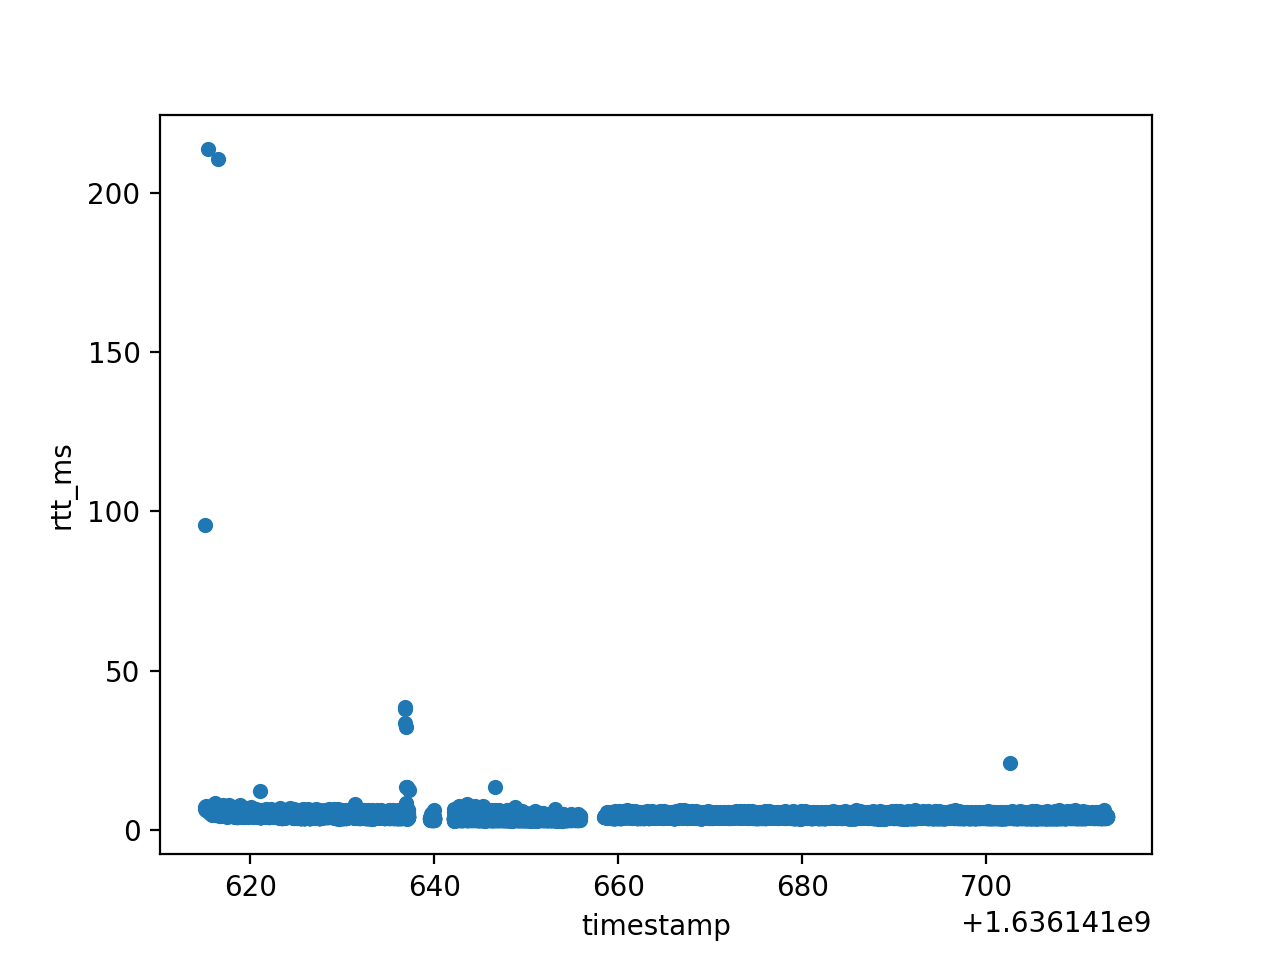

<AxesSubplot:xlabel='timestamp', ylabel='rtt_ms'>

In [8]:
%matplotlib notebook

rtts_df.plot.scatter(x="timestamp", y="rtt_ms")